## Imports

In [1]:
import os
import sys
import datetime

In [2]:
sys.path.append(os.path.join(os.pardir, 'src'))

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
from tqdm.notebook import tqdm

In [46]:
from CBO.distributions import Normal
from CBO.functions import rastrigin, rastrigin_c, square
from CBO.minimize import minimize
from CBO.visualizations import visualize_trajectory_convergence
from CBO.train import train, NeuralNetworkObjectiveFunction, TensorboardLogging, compute_model_dimensionality

## Data preparation

In [7]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def load_mnist_data():
    (X_train, y_train),(X_test, y_test) = mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_mnist_data()

## Model training

In [9]:
def build_default_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])

In [10]:
def build_small_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(10, activation='relu'),
    ])

In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
! rm -rf logs/fit

In [13]:
def conduct_tf_training(model, X_train, X_test, y_train, y_test, with_tensorboard=False,
                        model_description='', epoches=10):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    if with_tensorboard:
        log_dir = 'logs/fit/' + model_description
        if model_description is '':
            log_dir += datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test),
                  callbacks=[tensorboard_callback])
    else:
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test))
    
    return model

In [14]:
tensorboard_logging = TensorboardLogging('cbo_small', 'logs/fit')

In [15]:
cbo_small_model, trajectory = train(build_small_model(), loss, X_train, y_train, n_particles=100, 
                                    time_horizon=4,
                                    optimizer_config = {'alpha': 10, 'sigma': 0.4**0.5, 'dt': 0.1}, 
                                    initial_distribution=Normal(0, 1),
                                    return_trajectory=True, verbose=True, particles_batches=10, 
                                    dataset_batches=60, X_val=X_test, y_val=y_test, 
                                    tensorboard_logging=tensorboard_logging)


Timestamp: 6.0, loss: 2.308837890625, validation loss: 2.308980941772461


In [18]:
adam_small_model = conduct_tf_training(build_small_model(),
                                       X_train, X_test, y_train, y_test,
                                       with_tensorboard=True,
                                       model_description='adam_small', epoches=20)

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5648 - sparse_categorical_accuracy: 0.8514 - val_loss: 0.3170 - val_sparse_categorical_accuracy: 0.9072
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3189 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.2785 - val_sparse_categorical_accuracy: 0.9194
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2950 - sparse_categorical_accuracy: 0.9140 - val_loss: 0.2839 - val_sparse_categorical_accuracy: 0.9173
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2832 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.2601 - val_sparse_categorical_accuracy: 0.9229
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2780 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.2548 - val_sparse_categorical_accuracy: 0.9267
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2682 - spars

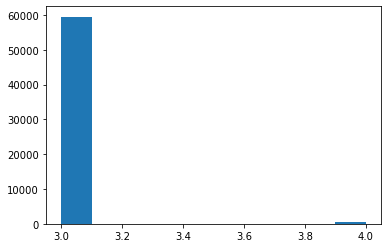

0.105

In [29]:
y_pred = tf.nn.softmax(cbo_small_model(X_train))
y_pred = np.argmax(y_pred.numpy(), axis=1)
plt.hist(y_pred)
plt.show()
np.mean(y_pred == y_train)

In [38]:
def visualize_particle_path_1d(trajectory, particle_ind, projection_dimenssion):
    timestamps = list(sorted(list(trajectory.keys())))
    particle_positions = [trajectory[ts]['particles'][particle_ind][projection_dimenssion]
                          for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, particle_positions)
    plt.xlabel('Timestamp')
    plt.ylabel('Particle position')
    plt.show()
    
def visalize_particles_shift(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    shifts = []
    for ind, ts in enumerate(timestamps[:-1]):
        shifts.append(tf.norm(trajectory[ts]['particles'] - trajectory[timestamps[ind + 1]]['particles'],
                              ord='euclidean'))
    plt.clf()
    plt.plot(timestamps[1:], shifts)
    plt.xlabel('Timestamp')
    plt.ylabel('Shift')
    plt.show()
    
def visalize_particles_std(trajectory, logarithmic=False):
    timestamps = list(sorted(list(trajectory.keys())))
    stds = []
    for ts in timestamps:
        stds.append(tf.math.reduce_std(trajectory[ts]['particles']))
    if logarithmic:
        stds = np.log(stds)
    plt.clf()
    plt.plot(timestamps, stds)
    plt.xlabel('Timestamp')
    plt.ylabel('Std')
    plt.show()

# contrains accuracies from different batches!
def visualize_cbo_accuracy(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    accuracies = [trajectory[ts]['accuracy'] for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, accuracies)
    plt.xlabel('Timestamp')
    plt.ylabel('Accuracy')
    plt.show()

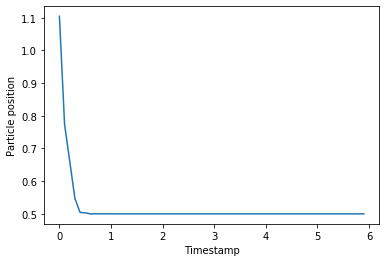

In [31]:
visualize_particle_path_1d(trajectory, 0, 0)

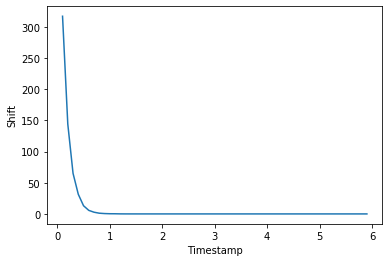

In [32]:
visalize_particles_shift(trajectory)

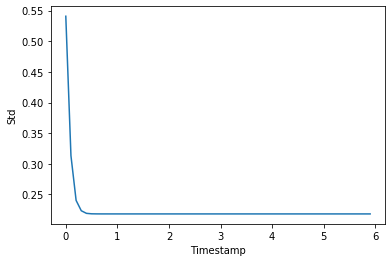

In [33]:
visalize_particles_std(trajectory)

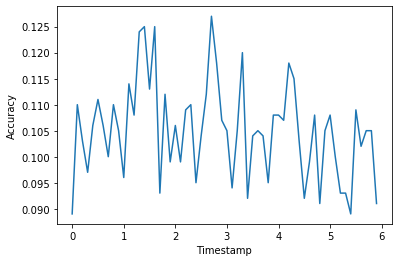

In [37]:
visualize_cbo_accuracy(trajectory)

In [39]:
def update_model_parameters(model, parameters):
    current_position = 0
    for weight in model.trainable_weights:
        next_position = current_position + tf.size(weight)
        weight.assign(tf.reshape(parameters[current_position:next_position], weight.shape))
        current_position = next_position
    return model

## Random initialization leads to unbalanced predictions of the initial model!

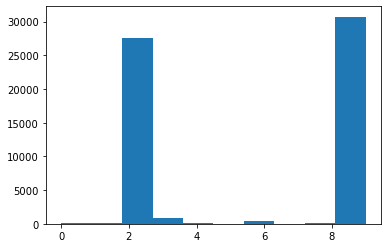

In [51]:
model = build_small_model()
initial_weights = tf.Variable(Normal(0, 1).sample(compute_model_dimensionality(model)))
model = update_model_parameters(model, initial_weights)
y_pred = np.argmax(tf.nn.softmax(model(X_train)), axis=1)
plt.hist(y_pred)
plt.show()